<a href="https://colab.research.google.com/github/WhyPtyo/Project-SDA-Klasifikasi-Hewan/blob/main/Klasifikasi_Hewan_Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Hewan di Zoo dengan Algoritma Tree

Implementasi algoritma Tree untuk klasifikasi dan pencarian taksonomi hewan berdasarkan dataset Zoo dan struktur hierarki taksonomi.

## 1. Persiapan Dataset

Pertama, kita perlu mengimport library yang diperlukan, kemudian mengupload file dataset dan struktur taksonomi. File-file ini akan digunakan untuk membangun Tree taksonomi dan melakukan pencarian spesies.

In [ ]:
# Mengimpor library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from google.colab import files

# Mengatur style plot
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### 1.1 Upload File Dataset dan Struktur Taksonomi

Upload file dataset (`zoo_dataset.csv`) dan struktur taksonomi (`taxonomy_structure.json`)

In [ ]:
# Upload file dataset dan struktur taksonomi
uploaded = files.upload()

# Pastikan file yang diperlukan telah diupload
required_files = ['zoo_dataset.csv', 'taxonomy_structure.json']
for file in required_files:
    if file not in uploaded:
        print(f"File {file} belum diupload. Silakan upload file tersebut.")

Saving taxonomy_structure.json to taxonomy_structure.json
Saving zoo_dataset.csv to zoo_dataset.csv


### 1.2 Membaca Dataset dan Struktur Taksonomi

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
# Membaca dataset
zoo_df = pd.read_csv('zoo_dataset.csv')

# Membaca struktur taksonomi
with open('taxonomy_structure.json', 'r') as f:
    taxonomy_structure = json.load(f)

# Menampilkan informasi dataset
print("Informasi Dataset:")
print(f"Jumlah data: {len(zoo_df)}")
print(f"Jumlah kelas: {len(taxonomy_structure)}")

# Menampilkan beberapa data pertama
print("\nBeberapa data pertama:")
data_table.DataTable(zoo_df, num_rows_per_page=5, max_columns=21)

Informasi Dataset:
Jumlah data: 22
Jumlah kelas: 3

Beberapa data pertama:


,animal_name,specific_name,class_name,order_name,type,hair,feathers,eggs,milk,airborne,...,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,kucing,Kucing (Felis catus),Mamalia,Karnivora,1,1,0,0,1,0,...,1,1,1,1,0,0,4,1,1,1
1,anjing,Anjing (Canis lupus familiaris),Mamalia,Karnivora,1,1,0,0,1,0,...,1,1,1,1,0,0,4,1,1,1
2,beruang,Beruang (Ursus arctos),Mamalia,Karnivora,1,1,0,0,1,0,...,1,1,1,1,0,0,4,1,0,1
3,sapi,Sapi (Bos taurus),Mamalia,Herbivora,1,1,0,0,1,0,...,0,1,1,1,0,0,4,1,1,1
4,kuda,Kuda (Equus ferus caballus),Mamalia,Herbivora,1,1,0,0,1,0,...,0,1,1,1,0,0,4,1,1,1
5,kambing,Kambing (Capra aegagrus hircus),Mamalia,Herbivora,1,1,0,0,1,0,...,0,1,1,1,0,0,4,1,1,1
6,gorila,Gorila (Gorilla gorilla),Mamalia,Primata,1,1,0,0,1,0,...,0,1,1,1,0,0,2,1,0,0
7,simpanse,Simpanse (Pan troglodytes),Mamalia,Primata,1,1,0,0,1,0,...,0,1,1,1,0,0,2,1,0,0
8,orangutan,Orangutan (Pongo pygmaeus),Mamalia,Primata,1,1,0,0,1,0,...,0,1,1,1,0,0,2,1,0,0
9,babi,Babi (Sus scrofa domesticus),Mamalia,Omnivora,1,1,0,0,1,0,...,0,1,1,1,0,0,4,1,1,1


## 2. Implementasi Algoritma Tree (DFS Pre Order)

Pada bagian ini, saya akan mengimplementasikan algoritma Tree untuk merepresentasikan struktur taksonomi hewan dan melakukan pencarian spesies.

### 2.1 Definisi Kelas Node dan AnimalTaxonomyTree

In [ ]:
class Node:
    def __init__(self, name, level, scientific_name=None, characteristics=None):
        self.name = name  # Nama node (kelas, ordo, atau spesies)
        self.level = level  # Level taksonomi (0: kingdom, 1: kelas, 2: ordo, 3: spesies)
        self.scientific_name = scientific_name  # Nama ilmiah (untuk spesies)
        self.characteristics = characteristics  # Karakteristik (untuk spesies)
        self.children = {}  # Dictionary untuk menyimpan child nodes

    def add_child(self, child_name, child_node):
        self.children[child_name] = child_node

    def get_child(self, child_name):
        return self.children.get(child_name)

    def has_child(self, child_name):
        return child_name in self.children

    def get_all_children(self):
        return self.children

    def __str__(self):
        if self.level == 3:  # Spesies
            return f"{self.name} ({self.scientific_name})"
        return self.name

class AnimalTaxonomyTree:
    def __init__(self, taxonomy_structure=None, dataset=None):
        self.root = Node("Hewan", 0)  # Root node adalah Kingdom Hewan
        self.dataset = dataset

        if taxonomy_structure:
            self.build_from_taxonomy(taxonomy_structure)

    def build_from_taxonomy(self, taxonomy_structure):
        # Iterasi melalui setiap kelas
        for class_name, class_data in taxonomy_structure.items():
            class_node = Node(class_name, 1)
            self.root.add_child(class_name, class_node)

            # Iterasi melalui setiap ordo dalam kelas
            for order_name, order_data in class_data['orders'].items():
                order_node = Node(order_name, 2)
                class_node.add_child(order_name, order_node)

                # Iterasi melalui setiap spesies dalam ordo
                for species_name, species_data in order_data['species'].items():
                    species_node = Node(
                        species_name,
                        3,
                        scientific_name=species_data['scientific_name'],
                        characteristics=species_data['characteristics']
                    )
                    order_node.add_child(species_name, species_node)

    def search(self, query):
        results = []

        # Iterasi melalui setiap kelas
        for class_name, class_node in self.root.get_all_children().items():
            # Iterasi melalui setiap ordo dalam kelas
            for order_name, order_node in class_node.get_all_children().items():
                # Iterasi melalui setiap spesies dalam ordo
                for species_name, species_node in order_node.get_all_children().items():
                    # Jika query cocok dengan nama spesies (case insensitive)
                    if query.lower() in species_name.lower():
                        results.append((species_node, class_name, order_name))

        return results

    def get_species_details(self, species_name):
        # Iterasi melalui setiap kelas
        for class_name, class_node in self.root.get_all_children().items():
            # Iterasi melalui setiap ordo dalam kelas
            for order_name, order_node in class_node.get_all_children().items():
                # Periksa apakah spesies ada dalam ordo ini
                if order_node.has_child(species_name):
                    species_node = order_node.get_child(species_name)
                    return (species_node, class_name, order_name)

        return None

    def get_path_to_species(self, species_name):
        result = self.get_species_details(species_name)
        if result:
            species_node, class_name, order_name = result
            return [self.root, self.root.get_child(class_name),
                   self.root.get_child(class_name).get_child(order_name),
                   species_node]
        return None

    def print_tree(self, node=None, level=0):
        if node is None:
            node = self.root

        # Cetak node saat ini dengan indentasi
        indent = "  " * level
        print(f"{indent}{node}")

        # Cetak semua child nodes secara rekursif
        for child_name, child_node in node.get_all_children().items():
            self.print_tree(child_node, level + 1)

    def print_species_details(self, species_name):
        result = self.get_species_details(species_name)
        if result:
            species_node, class_name, order_name = result

            print(f"Nama Spesies: {species_node.name}")
            print(f"Nama Ilmiah: {species_node.scientific_name}")
            print(f"Klasifikasi Taksonomi:")
            print(f"  Kingdom: Hewan")
            print(f"  Kelas: {class_name}")
            print(f"  Ordo: {order_name}")

            if species_node.characteristics:
                print("\nKarakteristik:")
                for key, value in species_node.characteristics.items():
                    print(f"  {key}: {value}")

            return True
        else:
            print(f"Spesies '{species_name}' tidak ditemukan.")
            return False

### 2.2 Membangun Tree Taksonomi

In [16]:
# Membangun Tree taksonomi
tree = AnimalTaxonomyTree(taxonomy_structure, zoo_df)

# Menampilkan informasi Tree
print(f"Tree taksonomi berhasil dibangun.")
print(f"Total kelas: {len(tree.root.get_all_children())}")

# Menampilkan beberapa level pertama dari Tree
print("\nStruktur Tree (2 level pertama):")
for class_name, class_node in tree.root.get_all_children().items():
    print(f"- {class_name}")
    for order_name in class_node.get_all_children().keys():
        print(f"  - {order_name}")

Tree taksonomi berhasil dibangun.
Total kelas: 3

Struktur Tree (2 level pertama):
- Mamalia
  - Karnivora
  - Herbivora
  - Omnivora
  - Primata
- Burung
  - Raptor
  - Penguin
  - Perenang
- Reptil
  - Ular
  - Kadal
  - Kura-kura


## 3. Visualisasi Tree Taksonomi

Pada bagian ini merupakan visualisasi Tree taksonomi

### 3.1 Visualisasi Tree Taksonomi Lengkap

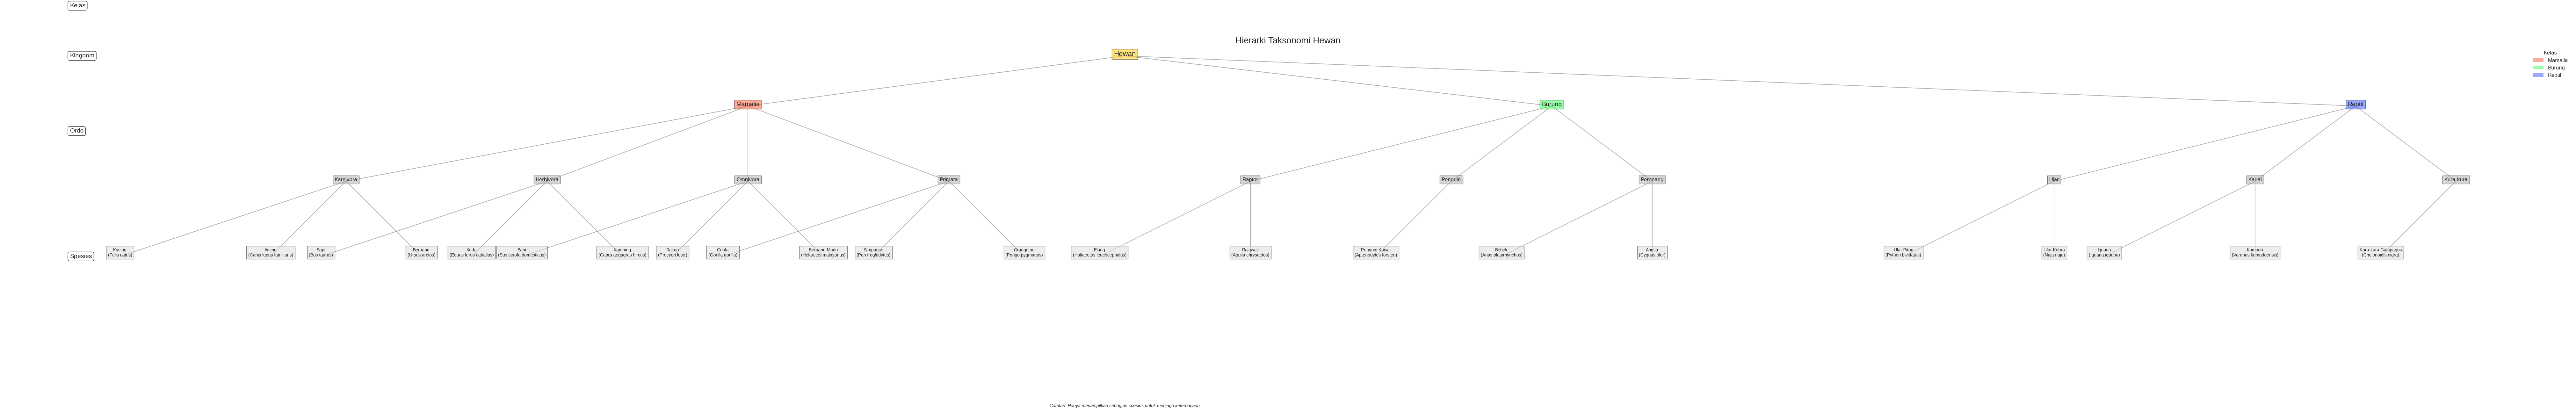

In [ ]:
def visualize_full_tree():
    # Buat figure
    plt.figure(figsize=(81, 20))

    # Posisi awal
    y_pos = 0

    # Gambar node root
    plt.text(0, y_pos, 'Hewan', fontsize=16, ha='center',
             bbox=dict(facecolor='#FFCC00', alpha=0.5))

    # Warna untuk setiap kelas
    class_colors = {
        'Mamalia': '#FF5733',
        'Burung': '#33FF57',
        'Reptil': '#3357FF'
    }

    # Gambar koneksi dari root ke kelas
    y_pos -= 1
    class_x_positions = {}

    # Hitung total width
    total_width = len(taxonomy_structure) * 5
    start_x = -total_width / 2

    # Gambar node kelas
    for i, (class_name, class_data) in enumerate(taxonomy_structure.items()):
        x_pos = start_x + i * 16
        class_x_positions[class_name] = x_pos

        # Gambar koneksi
        plt.plot([0, x_pos], [0, y_pos], 'k-', alpha=0.3)

        # Gambar node kelas
        plt.text(x_pos, y_pos, class_name, fontsize=14, ha='center',
                 bbox=dict(facecolor=class_colors.get(class_name, '#CCCCCC'), alpha=0.5))

    # Gambar koneksi dari kelas ke ordo
    y_pos -= 1.5
    order_x_positions = {}

    for class_name, class_data in taxonomy_structure.items():
        class_x = class_x_positions[class_name]
        orders = list(class_data['orders'].keys())

        # Hitung posisi x untuk setiap ordo
        order_width = 4
        order_start_x = class_x - (len(orders) * order_width) / 2

        for i, order_name in enumerate(orders):
            x_pos = order_start_x + i * order_width
            order_x_positions[f'{class_name}_{order_name}'] = x_pos

            # Gambar koneksi
            plt.plot([class_x, x_pos], [y_pos + 1.5, y_pos], 'k-', alpha=0.3)

            # Gambar node ordo
            plt.text(x_pos, y_pos, order_name, fontsize=12, ha='center',
                     bbox=dict(facecolor='#AAAAAA', alpha=0.5))

    # Gambar koneksi dari ordo ke beberapa spesies (tidak semua untuk menjaga keterbacaan)
    y_pos -= 1.5

    for class_name, class_data in taxonomy_structure.items():
        for order_name, order_data in class_data['orders'].items():
            order_x = order_x_positions[f'{class_name}_{order_name}']
            species = list(order_data['species'].keys())

            # Batasi jumlah spesies yang ditampilkan
            display_species = species[:3]

            # Hitung posisi x untuk setiap spesies
            species_width = 3
            species_start_x = order_x - (len(display_species) * species_width) / 2

            for i, species_name in enumerate(display_species):
                x_pos = species_start_x + i * species_width

                # Gambar koneksi
                plt.plot([order_x, x_pos], [y_pos + 1.5, y_pos], 'k-', alpha=0.3)

                # Gambar node spesies
                scientific_name = order_data['species'][species_name]['scientific_name']
                plt.text(x_pos, y_pos, f'{species_name}\n({scientific_name})', fontsize=10, ha='center',
                         bbox=dict(facecolor='#DDDDDD', alpha=0.5))

    # Tambahkan label untuk level
    # Posisi label di pojok kiri
    label_x = -total_width/2 - 13.5  # Posisi label di sebelah kiri

    # Tambahkan label untuk level di pojok kiri
    plt.text(label_x, 0, 'Kingdom', fontsize=14, ha='left', va='center',
             bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.3"))
    plt.text(label_x, y_pos + 5, 'Kelas', fontsize=14, ha='left', va='center',
             bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.3"))
    plt.text(label_x, y_pos + 2.5, 'Ordo', fontsize=14, ha='left', va='center',
             bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.3"))
    plt.text(label_x, y_pos, 'Spesies', fontsize=14, ha='left', va='center',
             bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.3"))

    # Tambahkan catatan
    plt.text(0, y_pos - 3, 'Catatan: Hanya menampilkan sebagian spesies untuk menjaga keterbacaan',
             fontsize=10, ha='center', style='italic')

    # Tambahkan legenda untuk warna kelas
    from matplotlib.patches import Rectangle
    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.5, label=class_name)
        for class_name, color in class_colors.items()
    ]
    plt.legend(handles=legend_elements, loc='upper right', title='Kelas')

    plt.title('Hierarki Taksonomi Hewan', fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualisasi Tree taksonomi lengkap
visualize_full_tree()

### 3.2 Visualisasi Tree Taksonomi untuk Kelas Tertentu

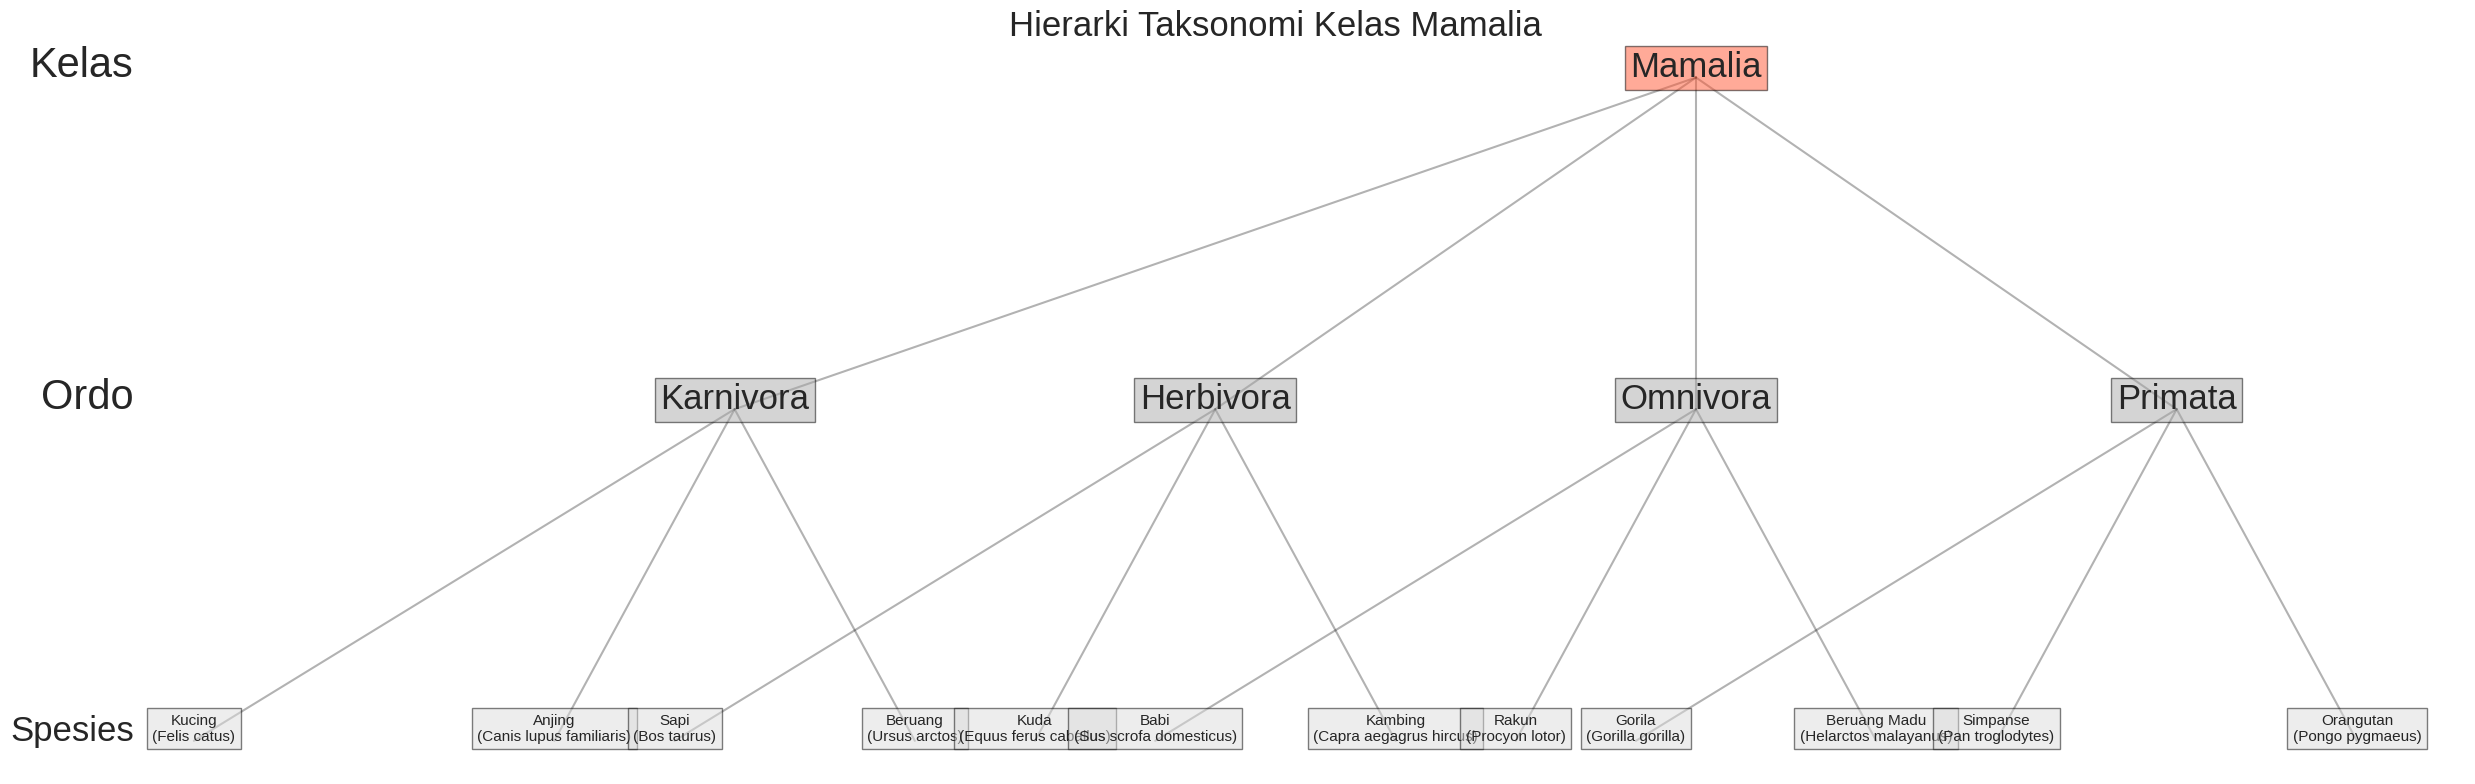

In [ ]:
def visualize_class_tree(class_name):
    if class_name not in taxonomy_structure:
        print(f"Kelas '{class_name}' tidak ditemukan.")
        return

    # Buat figure
    plt.figure(figsize=(25, 8))

    # Posisi awal
    y_pos = 0

    # Gambar node kelas
    plt.text(0, y_pos, class_name, fontsize=25, ha='center',
             bbox=dict(facecolor='#FF5733', alpha=0.5))

    # Gambar koneksi dari kelas ke ordo
    y_pos -= 1.5
    order_x_positions = {}

    class_data = taxonomy_structure[class_name]
    orders = list(class_data['orders'].keys())

    # Hitung posisi x untuk setiap ordo
    order_width = 4
    order_start_x = -(len(orders) * order_width) / 2

    for i, order_name in enumerate(orders):
        x_pos = order_start_x + i * order_width
        order_x_positions[order_name] = x_pos

        # Gambar koneksi
        plt.plot([0, x_pos], [0, y_pos], 'k-', alpha=0.3)

        # Gambar node ordo
        plt.text(x_pos, y_pos, order_name, fontsize=25, ha='center',
                 bbox=dict(facecolor='#AAAAAA', alpha=0.5))

    # Gambar koneksi dari ordo ke spesies
    y_pos -= 1.5

    for order_name, order_data in class_data['orders'].items():
        order_x = order_x_positions[order_name]
        species = list(order_data['species'].keys())

        # Hitung posisi x untuk setiap spesies
        species_width = 3
        species_start_x = order_x - (len(species) * species_width) / 2

        for i, species_name in enumerate(species):
            x_pos = species_start_x + i * species_width

            # Gambar koneksi
            plt.plot([order_x, x_pos], [y_pos + 1.5, y_pos], 'k-', alpha=0.3)

            # Gambar node spesies
            scientific_name = order_data['species'][species_name]['scientific_name']
            plt.text(x_pos, y_pos, f'{species_name}\n({scientific_name})', fontsize=11, ha='center',
                     bbox=dict(facecolor='#DDDDDD', alpha=0.5))

    # Tambahkan label untuk level
    plt.text(order_start_x - 5, 0, 'Kelas', fontsize=30, ha='right')
    plt.text(order_start_x - 5, y_pos + 1.5, 'Ordo', fontsize=30, ha='right')
    plt.text(order_start_x - 5, y_pos, 'Spesies', fontsize=25, ha='right')

    plt.title(f'Hierarki Taksonomi Kelas {class_name}', fontsize=25)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualisasi Tree taksonomi untuk kelas Mamalia
visualize_class_tree('Mamalia')

## 4. Fitur Pencarian Spesies

Pada bagian ini, kita akan mengimplementasikan fitur pencarian spesies berdasarkan nama dan menampilkan detail taksonominya.

In [ ]:
def search_species(tree, query):
    results = tree.search(query)

    if results:
        print(f"Ditemukan {len(results)} hasil untuk '{query}':")
        for i, (species_node, class_name, order_name) in enumerate(results, 1):
            print(f"{i}. {species_node.name} ({species_node.scientific_name}) - Kelas: {class_name}, Ordo: {order_name}")
    else:
        print(f"Tidak ditemukan hasil untuk '{query}'.")

    return results

In [19]:
# Contoh pencarian spesies
query = "Babi"  # Ganti dengan query pencarian yang diinginkan
results = search_species(tree, query)

Ditemukan 1 hasil untuk 'Babi':
1. Babi (Sus scrofa domesticus) - Kelas: Mamalia, Ordo: Omnivora


In [20]:
# Menampilkan detail spesies dari hasil pencarian
if results:
    # Pilih spesies pertama dari hasil pencarian
    species_node, _, _ = results[0]
    print("\nDetail spesies:")
    tree.print_species_details(species_node.name)


Detail spesies:
Nama Spesies: Babi
Nama Ilmiah: Sus scrofa domesticus
Klasifikasi Taksonomi:
  Kingdom: Hewan
  Kelas: Mamalia
  Ordo: Omnivora

Karakteristik:
  hair: 1
  feathers: 0
  eggs: 0
  milk: 1
  airborne: 0
  aquatic: 0
  predator: 0
  toothed: 1
  backbone: 1
  breathes: 1
  venomous: 0
  fins: 0
  legs: 4
  tail: 1
  domestic: 1
  catsize: 1


### 4.1 Implementasi Pencarian dengan GUI Sederhana

In [21]:
results = search_species(tree, input("Masukkan nama hewan = "))


Masukkan nama hewan = sapi
Ditemukan 1 hasil untuk 'sapi':
1. Sapi (Bos taurus) - Kelas: Mamalia, Ordo: Herbivora


In [22]:
if results:
    # Pilih spesies pertama dari hasil pencarian
    species_node, _, _ = results[0]
    print("\nDetail spesies:")
    tree.print_species_details(species_node.name)


Detail spesies:
Nama Spesies: Sapi
Nama Ilmiah: Bos taurus
Klasifikasi Taksonomi:
  Kingdom: Hewan
  Kelas: Mamalia
  Ordo: Herbivora

Karakteristik:
  hair: 1
  feathers: 0
  eggs: 0
  milk: 1
  airborne: 0
  aquatic: 0
  predator: 0
  toothed: 1
  backbone: 1
  breathes: 1
  venomous: 0
  fins: 0
  legs: 4
  tail: 1
  domestic: 1
  catsize: 1


**Karena Github tidak support untuk ipywidgets, jadi saya jadikan komentar**

In [ ]:
"""
import ipywidgets as widgets
from IPython.display import display, clear_output

# Membuat widget pencarian
search_input = widgets.Text(
    value='',
    placeholder='Masukkan nama spesies',
    description='Cari:',
    disabled=False
)

search_button = widgets.Button(
    description='Cari',
    disabled=False,
    button_style='primary',
    tooltip='Klik untuk mencari',
    icon='search'
)

output = widgets.Output()

# Fungsi untuk menangani klik tombol pencarian
def on_search_button_clicked(b):
    with output:
        clear_output()
        query = search_input.value
        if query:
            results = search_species(tree, query)

            if results:
                # Buat dropdown untuk memilih spesies
                options = [(f"{species_node.name} ({species_node.scientific_name})", i) for i, (species_node, _, _) in enumerate(results)]

                # Buat widget dropdown dan simpan referensinya di variabel species_dropdown
                species_dropdown = widgets.Dropdown(
                    options=options,
                    description='Pilih:',
                    disabled=False,
                )

                detail_button = widgets.Button(
                    description='Lihat Detail',
                    disabled=False,
                    button_style='info',
                    tooltip='Klik untuk melihat detail',
                    icon='info'
                )

                detail_output = widgets.Output()

                # Fungsi untuk menangani klik tombol Lihat Detail
                def on_detail_button_clicked(b):
                    with detail_output:
                        clear_output()
                        # Ambil nilai dari widget dropdown yang sudah ditampilkan
                        selected_index = species_dropdown.value
                        # Lengkapi pernyataan if di sini
                        if selected_index is not None:
                            # Ambil data spesies berdasarkan indeks yang dipilih
                            species_node, _, _ = results[selected_index]
                            print("\nDetail spesies:")
                            tree.print_species_details(species_node.name)
                        else:
                            print("Silakan pilih spesies dari dropdown.")

                # Menghubungkan detail_button ke fungsi penanganan klik
                detail_button.on_click(on_detail_button_clicked)

                # Tampilkan semua widget dalam satu VBox untuk struktur yang lebih baik
                display(widgets.VBox([
                    widgets.HBox([species_dropdown, detail_button]),
                    detail_output
                ]))
            else:
                print("Tidak ada hasil yang ditemukan.")
        else:
            print("Masukkan nama spesies untuk dicari.")

# Menghubungkan fungsi dengan tombol pencarian
search_button.on_click(on_search_button_clicked)

# Menampilkan widget pencarian
display(widgets.HBox([search_input, search_button]))
display(output) """

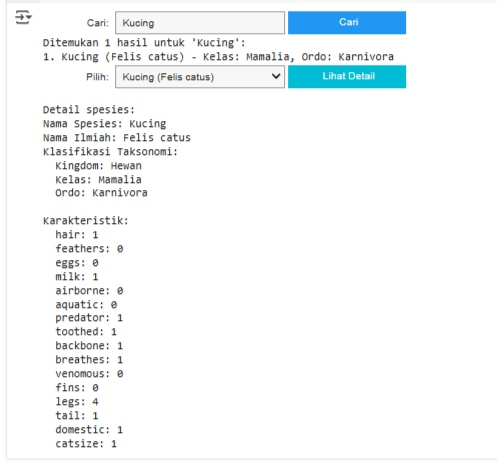

## 5. Visualisasi Path dari Root ke Spesies

Pada bagian ini, kita akan membuat visualisasi jalur dari root ke spesies tertentu.

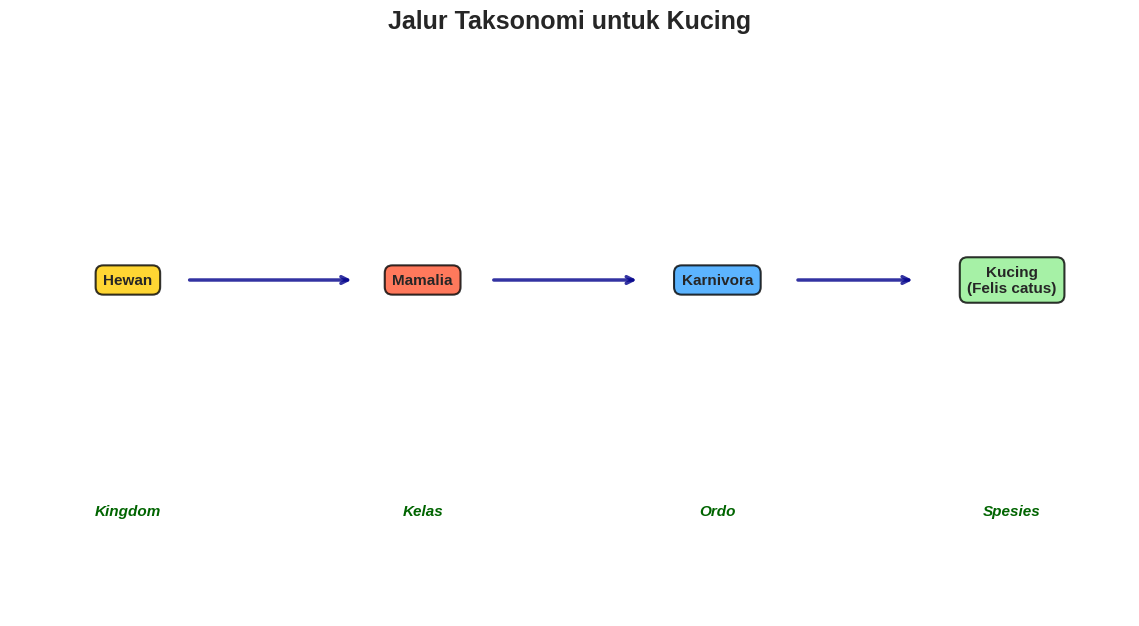

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_path_to_species(tree, species_name):
    path = tree.get_path_to_species(species_name)
    if not path:
        print(f"Spesies '{species_name}' tidak ditemukan.")
        return

    # Buat figure dengan ukuran yang lebih besar
    plt.figure(figsize=(14, 8))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.15)

    # Posisi node
    positions = [(i * 2.5, 0) for i in range(len(path))]  # Jarak lebih lebar antar node

    # Warna node
    colors = ['#FFCC00', '#FF5733', '#33A1FF', '#90EE90']

    # Estimasi lebar kotak berdasarkan teks (approximate)
    box_widths = []
    box_heights = []

    for i, node in enumerate(path):
        if i == len(path) - 1:  # Spesies
            text = f'{node.name}\n({node.scientific_name})'
        else:
            text = node.name

        # Estimasi ukuran kotak berdasarkan panjang teks
        lines = text.split('\n')
        max_line_length = max(len(line) for line in lines)

        # Faktor konversi approximate (bisa disesuaikan)
        width = max_line_length * 0.08 + 0.4  # Lebar minimum 0.4
        height = len(lines) * 0.15 + 0.2      # Tinggi minimum 0.2

        box_widths.append(width)
        box_heights.append(height)

    # Gambar node dan simpan text objects untuk mendapat ukuran sebenarnya
    text_objects = []
    for i, (node, pos) in enumerate(zip(path, positions)):
        # Gambar node
        if i == len(path) - 1:  # Spesies
            text_obj = plt.text(pos[0], pos[1], f'{node.name}\n({node.scientific_name})',
                    fontsize=11, ha='center', va='center', weight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor=colors[i % len(colors)],
                             alpha=0.8, edgecolor='black', linewidth=1.5))
        else:
            text_obj = plt.text(pos[0], pos[1], node.name,
                    fontsize=11, ha='center', va='center', weight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor=colors[i % len(colors)],
                             alpha=0.8, edgecolor='black', linewidth=1.5))
        text_objects.append(text_obj)

    # Setelah gambar text, hitung posisi panah yang tepat
    for i in range(len(path) - 1):
        current_pos = positions[i]
        next_pos = positions[i + 1]

        # Hitung offset untuk menghindari kotak
        # Panah horizontal, jadi kita perlu offset di sumbu X
        arrow_start_x = current_pos[0] + box_widths[i] / 2 + 0.1  # Keluar dari kanan kotak
        arrow_end_x = next_pos[0] - box_widths[i + 1] / 2 - 0.1   # Masuk ke kiri kotak berikutnya

        # Y tetap sama (horizontal arrow)
        arrow_start_y = current_pos[1]
        arrow_end_y = next_pos[1]

        # Buat panah dengan posisi yang sudah disesuaikan
        plt.annotate('',
                    xy=(arrow_end_x, arrow_end_y),
                    xytext=(arrow_start_x, arrow_start_y),
                    arrowprops=dict(arrowstyle='->', lw=2.5, color='darkblue', alpha=0.8))

    # Tambahkan label untuk level
    level_labels = ['Kingdom', 'Kelas', 'Ordo', 'Spesies']
    for i, label in enumerate(level_labels[:len(path)]):
        plt.text(positions[i][0], -0.8, label, fontsize=11, ha='center', va='top',
                style='italic', color='darkgreen', weight='bold')

    # Atur judul
    plt.title(f'Jalur Taksonomi untuk {species_name}', fontsize=18, fontweight='bold', pad=20)

    # Atur batas axis
    plt.xlim(-1, positions[-1][0] + 1)
    plt.ylim(-1.2, 0.8)

    plt.axis('off')
    plt.show()

# Visualisasi jalur dari root ke spesies
visualize_path_to_species(tree, 'Kucing')

Note : DFS

## 6. Kesimpulan

Dalam notebook ini merupakan implementasi algoritma Tree untuk klasifikasi dan pencarian taksonomi hewan. yaitu:


1. Mengimplementasikan algoritma Tree untuk merepresentasikan struktur taksonomi hewan
2. Membuat visualisasi Tree taksonomi
3. Menambahkan fitur pencarian spesies dan menampilkan detail taksonominya
4. Mengimplementasikan widget pencarian

Algoritma Tree sangat cocok untuk merepresentasikan struktur hierarki seperti taksonomi hewan karena memungkinkan kita untuk menyimpan dan mengakses informasi dengan cara yang terstruktur dan efisien. Dengan menggunakan algoritma Tree, kita dapat dengan mudah melakukan pencarian, navigasi, dan visualisasi struktur taksonomi hewan.

DAFTAR PUSTAKA

[1] E. Widiyadi, "Penerapan Tree dalam Klasifikasi dan Determinasi Makhluk Hidup," Makalah IF2091 Struktur Diskrit, Program Studi Teknik Informatika, STEI ITB, 2010. Diakses dari https://informatika.stei.itb.ac.id/~rinaldi.munir/Matdis/2009-2010/Makalah0910/MakalahStrukdis0910-084.pdf. [Diakses pada 13 Mei 2025]

[2] R. G. Forsyth, "Zoo Data Set," UCI Machine Learning Repository, 1990. Diakses dari : https://archive.ics.uci.edu/dataset/111/zoo. [Diakses pada 19 Mei 2025]

[3] S. Olmstead, "Animal-Classification-Decision-Tree," repositori GitHub, 2021. . Diakses dari : https://github.com/summerolmstead/Animal-Classification-Decision-Tree. [Diakses pada 19 Mei 2025]

[4] C.1, "Decision Tree Classification using Zoo (Animals)," Kaggle, 2018.. Diakses dari : https://www.kaggle.com/code/carrie1/decision-tree-classification-using-zoo-animals/notebook. [Diakses pada 19 Mei 2025]

[5] M. A. Nawaz, V. T. Ngo, dan A. M. A. Haris, "ANIMAL CLASSIFICATION IN WILDLIFE THROUGH IMAGES USING STATISTICAL METHODS AND DECISION TREE," Term Paper, Rhine-Waal University of Applied Sciences, 2015. Tersedia: https://www.researchgate.net/publication/315146311.  [Diakses pada 19 Mei 2025]

[6]  T. Ngo, "Classify Animals with Machine Learning," Science Buddies. Diakses dari : https://www.sciencebuddies.org/science-fair-projects/project-ideas/ArtificialIntelligence_p018/artificial-intelligence/animal_classification. [Diakses pada 19 Mei 2025]
